# Random Forest, ExtraTrees y Boosting en Scikit Learn

## 1. Importamos la Matriz de Features y el Vector Objetivo



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_features = pd.read_csv('df_features.csv', sep = ';', low_memory=False, index_col = 0)
# Ver por qué usan Low Memory = False

print (df_features.shape)
print (' ')

# Verificamos desbalance de clases
print(df_features.loc[:,'mora_hoy'].value_counts(normalize=True))

# Asignamos la matriz de features y el vector objetivo
X = df_features.drop(['mora_hoy'], axis=1)
y = df_features['mora_hoy']

# Hacemos el test-train split con 25% de los datos en test, utilizando stratify en base
# al vector objetivo "y"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25,
        random_state=12, stratify=y)

(4088, 470)
 
0    0.795744
1    0.204256
Name: mora_hoy, dtype: float64


Para que los resultados sean consistentes hay que exponer los modelos exactamente al mismo esquema de validación cruzada.

In [3]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

## 2. Comparamos la performance de los árboles de decisión y ensambles de modelos
 
Modelos Evaluados:
- Árboles de decisión
- Bagging sobre Árboles de decisión
- Random Forest
- Extra Trees
- Adda Boost
- Gradient Boosting
- Cat Boost


Para comparar los diferentes algoritmos armamos la siguiente función. Toma como input un estimador y un string con el nombre que le quieran poner, y ejecuta un `cross_val_score`

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

lista_rend = []
def evaluar_rendimiento(modelo, nombre, X_train, y_train, cv):
    s = cross_val_score(modelo, X_train, y_train, cv=cv, n_jobs=-1)
    lista_rend.append({'modelo':modelo, 'nombre':nombre, 
        'exactitud': s.mean().round(3), 'std': s.std().round(3)})
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))

In [5]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=1)
bdt = BaggingClassifier(dt, random_state=1)
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
et = ExtraTreesClassifier(class_weight='balanced', random_state=1)
ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=1), n_estimators=100)
gb = GradientBoostingClassifier()
cb = CatBoostClassifier()

evaluar_rendimiento(dt,  "Árbol de decisión", X_train, y_train, cv)
evaluar_rendimiento(bdt, "Bagging AD", X_train, y_train, cv)
evaluar_rendimiento(rf,  "Random Forest", X_train, y_train, cv)
evaluar_rendimiento(et,  "Extra Trees", X_train, y_train, cv)
evaluar_rendimiento(ab, "AdaBoostClassifier",  X_train, y_train, cv)
evaluar_rendimiento(gb, "GradientBoostingClassifier", X_train, y_train, cv)
evaluar_rendimiento(cb, "CatBoostClassifier", X_train, y_train, cv)

Rendimiento de Árbol de decisión:	0.748 ± 0.003
Rendimiento de Bagging AD:	0.807 ± 0.003
Rendimiento de Random Forest:	0.804 ± 0.003
Rendimiento de Extra Trees:	0.803 ± 0.012
Rendimiento de AdaBoostClassifier:	0.812 ± 0.01
Rendimiento de GradientBoostingClassifier:	0.807 ± 0.005
Rendimiento de CatBoostClassifier:	0.809 ± 0.007


## 3. Optimizamos los hiperparámetros de RandomForest, AdaBoost,  Gradient Boosting y CatBoost

### `Random Forest`

In [6]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#param_trees = {'n_estimators': [50, 100, 200], 
 #              'max_features': [1, 5, 8, 10, 21], 
  #             'max_depth': [5, 20, 50, 70, 100], 
   #            'min_samples_leaf':[1, 5, 8, 10, 50]}
param_trees = {'n_estimators': [100, 200, 300, 400], 
               'max_features': [35, 43, 51, 59, 67, 93, 175], 
               'max_depth': [50, 70, 100, 120], 
               'min_samples_leaf':[1, 3, 5]} #siempre dio 1 como mejor min_sample_leaf, bajamos los casos a 3

In [7]:
grid_search_rf = GridSearchCV(rf, param_grid=param_trees, cv=cv, verbose=1, n_jobs=-1)

In [8]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 336 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed: 18.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'max_features': [35, 43, 51, 59, 67, 93, 175], 'max_depth': [50, 70, 100, 120], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [9]:
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features=59,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [10]:
evaluar_rendimiento(grid_search_rf.best_estimator_,  "Random Forest GS", X_train, y_train, cv)

Rendimiento de Random Forest GS:	0.815 ± 0.012


### `AdaBoostClassifier()`

In [11]:
#params_ab = {"n_estimators": [100, 500],
 #         "learning_rate":[0.01, 0.1, 1.0],
  #      "base_estimator__max_depth": [1, 2, 3]}

#grid_ab = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 
 #                      param_grid=params_ab, cv=cv, verbose=1, n_jobs=-1)

params_ab = {"n_estimators": [100, 300, 500, 800],
          "learning_rate":[0.01, 0.05, 0.08, 0.1, 0.17, 0.30, 0.5, 0.8],
        "base_estimator__max_depth": [2, 3, 4, 5]}

rand_ab = RandomizedSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 
             param_distributions=params_ab, cv=cv, n_iter = 70, verbose=1, n_jobs=-1)



In [12]:
#grid_ab.fit(X_train, y_train)
rand_ab.fit(X_train, y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 14.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
          error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=70, n_jobs=-1,
          param_distributions={'n_estimators': [100, 300, 500, 800], 'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.17, 0.3, 0.5, 0.8], 'base_estimator__max_depth': [2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [13]:
#grid_ab.best_estimator_
rand_ab.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.3, n_estimators=100, random_state=None)

In [14]:
#evaluar_rendimiento(grid_ab.best_estimator_,  "AdaBoostClassifier + GS", X_train, y_train, cv)
evaluar_rendimiento(rand_ab.best_estimator_,  "AdaBoostClassifier + RS", \
                                                             X_train, y_train, cv)


Rendimiento de AdaBoostClassifier + RS:	0.824 ± 0.008


### `GradientBoostingClassifier()`

In [15]:
#params_gb = {'n_estimators':[100, 500] , 
 #            'learning_rate':[0.001, 0.001, 0.1, 1.0],
  #          'max_depth' : [1, 2, 3, 4]}

params_gb = {'n_estimators':[600, 800, 1000] , 
             'learning_rate':[0.01, 0.05, 0.1, 0.5, 1.0],
            'max_depth' : [4, 6, 8]}

grid_gb = GridSearchCV(gb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=-1)

In [16]:
grid_gb.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 21.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [600, 800, 1000], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0], 'max_depth': [4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [17]:
grid_gb.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
evaluar_rendimiento(grid_gb.best_estimator_, "GradientBoostingClassifier + GS", X_train, y_train, cv)

Rendimiento de GradientBoostingClassifier + GS:	0.815 ± 0.008


### `CatBoostClassifier()`

In [19]:
params_cb = {"n_estimators": [100, 200, 300, 400, 500],
             "learning_rate":[0.01, 0.05, 0.08, 0.1, 0.13, 0.17, 0.30, 0.6, 0.8, 1.0],
             "max_depth": [1, 2, 3, 4, 5]}

rand_cb = RandomizedSearchCV(cb, param_distributions=params_cb, n_iter = 70, \
                                                        verbose= True, n_jobs=-1, cv=cv)

#grid_cb = GridSearchCV(cb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=-1)

In [20]:
rand_cb.fit(X_train, y_train)
#grid_cb.fit(X_train, y_train)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 66.9min finished


0:	learn: 0.6550638	total: 108ms	remaining: 54s
1:	learn: 0.6172741	total: 140ms	remaining: 34.9s
2:	learn: 0.5931924	total: 171ms	remaining: 28.4s
3:	learn: 0.5701786	total: 211ms	remaining: 26.2s
4:	learn: 0.5500003	total: 242ms	remaining: 23.9s
5:	learn: 0.5361551	total: 275ms	remaining: 22.7s
6:	learn: 0.5227472	total: 310ms	remaining: 21.9s
7:	learn: 0.5116456	total: 404ms	remaining: 24.8s
8:	learn: 0.5029847	total: 435ms	remaining: 23.7s
9:	learn: 0.4964225	total: 468ms	remaining: 22.9s
10:	learn: 0.4912257	total: 499ms	remaining: 22.2s
11:	learn: 0.4850005	total: 566ms	remaining: 23s
12:	learn: 0.4828387	total: 597ms	remaining: 22.4s
13:	learn: 0.4793549	total: 629ms	remaining: 21.8s
14:	learn: 0.4763018	total: 662ms	remaining: 21.4s
15:	learn: 0.4718675	total: 693ms	remaining: 21s
16:	learn: 0.4692204	total: 729ms	remaining: 20.7s
17:	learn: 0.4669271	total: 761ms	remaining: 20.4s
18:	learn: 0.4643667	total: 824ms	remaining: 20.9s
19:	learn: 0.4618929	total: 856ms	remaining: 20

162:	learn: 0.3479040	total: 7.57s	remaining: 15.6s
163:	learn: 0.3470015	total: 7.6s	remaining: 15.6s
164:	learn: 0.3467266	total: 7.63s	remaining: 15.5s
165:	learn: 0.3465426	total: 7.67s	remaining: 15.4s
166:	learn: 0.3462805	total: 7.78s	remaining: 15.5s
167:	learn: 0.3460171	total: 7.89s	remaining: 15.6s
168:	learn: 0.3455833	total: 8.01s	remaining: 15.7s
169:	learn: 0.3454253	total: 8.09s	remaining: 15.7s
170:	learn: 0.3446039	total: 8.13s	remaining: 15.6s
171:	learn: 0.3444539	total: 8.16s	remaining: 15.6s
172:	learn: 0.3440387	total: 8.21s	remaining: 15.5s
173:	learn: 0.3438346	total: 8.26s	remaining: 15.5s
174:	learn: 0.3437279	total: 8.3s	remaining: 15.4s
175:	learn: 0.3435179	total: 8.34s	remaining: 15.3s
176:	learn: 0.3433574	total: 8.37s	remaining: 15.3s
177:	learn: 0.3430805	total: 8.4s	remaining: 15.2s
178:	learn: 0.3428365	total: 8.43s	remaining: 15.1s
179:	learn: 0.3426633	total: 8.47s	remaining: 15.1s
180:	learn: 0.3413900	total: 8.52s	remaining: 15s
181:	learn: 0.340

321:	learn: 0.2941451	total: 16.6s	remaining: 9.15s
322:	learn: 0.2932035	total: 16.6s	remaining: 9.09s
323:	learn: 0.2930870	total: 16.6s	remaining: 9.03s
324:	learn: 0.2929835	total: 16.7s	remaining: 8.97s
325:	learn: 0.2928326	total: 16.7s	remaining: 8.91s
326:	learn: 0.2924674	total: 16.7s	remaining: 8.85s
327:	learn: 0.2921567	total: 16.8s	remaining: 8.78s
328:	learn: 0.2918304	total: 16.8s	remaining: 8.73s
329:	learn: 0.2916468	total: 16.9s	remaining: 8.68s
330:	learn: 0.2915087	total: 16.9s	remaining: 8.62s
331:	learn: 0.2913233	total: 16.9s	remaining: 8.56s
332:	learn: 0.2911957	total: 17s	remaining: 8.5s
333:	learn: 0.2899262	total: 17s	remaining: 8.45s
334:	learn: 0.2898195	total: 17.1s	remaining: 8.4s
335:	learn: 0.2895699	total: 17.1s	remaining: 8.34s
336:	learn: 0.2894332	total: 17.1s	remaining: 8.28s
337:	learn: 0.2893722	total: 17.2s	remaining: 8.23s
338:	learn: 0.2893235	total: 17.2s	remaining: 8.17s
339:	learn: 0.2892739	total: 17.2s	remaining: 8.11s
340:	learn: 0.2888

484:	learn: 0.2605451	total: 24.5s	remaining: 757ms
485:	learn: 0.2603937	total: 24.5s	remaining: 706ms
486:	learn: 0.2603530	total: 24.5s	remaining: 655ms
487:	learn: 0.2602422	total: 24.6s	remaining: 604ms
488:	learn: 0.2600761	total: 24.6s	remaining: 555ms
489:	learn: 0.2598043	total: 24.7s	remaining: 504ms
490:	learn: 0.2595794	total: 24.8s	remaining: 454ms
491:	learn: 0.2594745	total: 24.9s	remaining: 404ms
492:	learn: 0.2590287	total: 24.9s	remaining: 354ms
493:	learn: 0.2589407	total: 25s	remaining: 303ms
494:	learn: 0.2587227	total: 25s	remaining: 253ms
495:	learn: 0.2582821	total: 25.1s	remaining: 202ms
496:	learn: 0.2579790	total: 25.1s	remaining: 152ms
497:	learn: 0.2579231	total: 25.2s	remaining: 101ms
498:	learn: 0.2574582	total: 25.2s	remaining: 50.6ms
499:	learn: 0.2573873	total: 25.3s	remaining: 0us


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
          error_score='raise-deprecating',
          estimator=<catboost.core.CatBoostClassifier object at 0x1a18228eb8>,
          fit_params=None, iid='warn', n_iter=70, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.13, 0.17, 0.3, 0.6, 0.8, 1.0], 'max_depth': [1, 2, 3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=True)

In [21]:
rand_cb.best_estimator_
#grid_cb.best_estimator_

In [22]:
evaluar_rendimiento(rand_cb.best_estimator_, "CatBoostClassifier + RS", \
                    X_train, y_train, cv)
#evaluar_rendimiento(grid_cb.best_estimator_, "CatBoostClassifier + GS", \
 #                  X_train, y_train, cv)

Rendimiento de CatBoostClassifier + RS:	0.819 ± 0.005


In [23]:
# Vemos los resultados para las distintas corridas con datos de entrenamiento
df_rendimientos = pd.DataFrame(lista_rend)
df_rendimiento = df_rendimientos[['nombre', 'exactitud', 'std', 'modelo']]
df_rendimiento

,nombre,exactitud,std,modelo
0,Árbol de decisión,0.748,0.003,DecisionTreeClassifier(class_weight='balanced'...
1,Bagging AD,0.807,0.003,BaggingClassifier(base_estimator=DecisionTreeC...
2,Random Forest,0.804,0.003,"RandomForestClassifier(bootstrap=True, class_w..."
3,Extra Trees,0.803,0.012,"ExtraTreesClassifier(bootstrap=False, class_we..."
4,AdaBoostClassifier,0.812,0.010,"AdaBoostClassifier(algorithm='SAMME.R',\n ..."
5,GradientBoostingClassifier,0.807,0.005,GradientBoostingClassifier(criterion='friedman...
6,CatBoostClassifier,0.809,0.007,<catboost.core.CatBoostClassifier object at 0x...
7,Random Forest GS,0.815,0.012,"(DecisionTreeClassifier(class_weight=None, cri..."
8,AdaBoostClassifier + RS,0.824,0.008,"(DecisionTreeClassifier(class_weight=None, cri..."
9,GradientBoostingClassifier + GS,0.815,0.008,([DecisionTreeRegressor(criterion='friedman_ms...


## 4. Evaluamos el Rendimiento con Datos de Prueba (Testeo)

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import binarize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [25]:
# Definimos una función para encontrar el umbral óptimo dada nuestra funcion de costos
def evaluar_umbral (corrida, modelo, nombre, y_proba):
    lista_umbrales = []
    for i in np.arange(0,0.55,.05):
        y_pred = binarize(y_proba, i)[:,1]
        confusion = confusion_matrix(y_test,y_pred)
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        total = TP + TN + FP + FN
        recall = round(TP/(TP+FN),3) * 100
        precision = round(TP/(TP+FP),3) * 100
        cost_fn = round(FP/total * .249 + FN/total,3)*100
        nueva_mora = round(FN/total,3) * 100
        exactitud = round((TN + TP) / total, 3) * 100
        lista_umbrales.append({'corrida': corrida, 'umbral': i,  
             'nueva_mora (FN)':nueva_mora, 'cost_fn': cost_fn,
             'recall':recall, 'precision':precision, 'exactitud': exactitud,
             'modelo': modelo, 'nombre':nombre})
    return lista_umbrales
    #print ('Umbral = {0:.2f} Cost_fn = {1:.3f}'.format(i, cost_fn))

In [26]:
# Definimos una función para evaluar resultados con datos de testeo
lista_testeo = []
def evaluar_testeo(corrida, modelo, nombre, X_test, y_test):
    modelo.fit(X_train, y_train) # Hacemos Fit del Modelo
    y_proba = modelo.predict_proba(X_test) # Obtenemos las probab. de clasificación
    lista_testeo.append(evaluar_umbral(corrida, modelo, nombre, y_proba))

In [68]:
# Verificamos el Accuracy y la Función de Costos de cada modelo con los datos de Testeo
lista_umbrales = []
lista_testeo = []
evaluar_testeo(0, dt, "Árbol de decisión", X_test, y_test)
evaluar_testeo(1, bdt, "Bagging AD", X_test, y_test)
evaluar_testeo(2, rf, "Random Forest", X_test, y_test)
evaluar_testeo(3, grid_search_rf.best_estimator_, \
                "Random Forest Grid Search", X_test, y_test)

evaluar_testeo(4, et, "Extra Trees", X_test, y_test)
#evaluar_testeo(5, grid_ab.best_estimator_, \
           #     "AdaBoostClassifier Grid Search", X_test, y_test)

evaluar_testeo(5, rand_ab.best_estimator_, \
                "AdaBoostClassifier Random Search", X_test, y_test)

evaluar_testeo(6, gb, "GradientBoostingClassifier", X_test, y_test)
evaluar_testeo(7, grid_gb.best_estimator_, \
                "GradientBoostingClassifier Grid Search", X_test, y_test)

evaluar_testeo(8, rand_cb.best_estimator_, \
               "CatBoostClassifier Random Search", X_test, y_test)
#evaluar_testeo(8, grid_cb.best_estimator_, \
         #      "CatBoostClassifier Grid Search", X_test, y_test)

0:	learn: 0.6550638	total: 38.2ms	remaining: 19.1s
1:	learn: 0.6172741	total: 70.8ms	remaining: 17.6s
2:	learn: 0.5931924	total: 102ms	remaining: 16.8s
3:	learn: 0.5701786	total: 132ms	remaining: 16.4s
4:	learn: 0.5500003	total: 166ms	remaining: 16.5s
5:	learn: 0.5361551	total: 207ms	remaining: 17.1s
6:	learn: 0.5227472	total: 244ms	remaining: 17.2s
7:	learn: 0.5116456	total: 312ms	remaining: 19.2s
8:	learn: 0.5029847	total: 345ms	remaining: 18.8s
9:	learn: 0.4964225	total: 379ms	remaining: 18.6s
10:	learn: 0.4912257	total: 412ms	remaining: 18.3s
11:	learn: 0.4850005	total: 450ms	remaining: 18.3s
12:	learn: 0.4828387	total: 505ms	remaining: 18.9s
13:	learn: 0.4793549	total: 540ms	remaining: 18.8s
14:	learn: 0.4763018	total: 576ms	remaining: 18.6s
15:	learn: 0.4718675	total: 609ms	remaining: 18.4s
16:	learn: 0.4692204	total: 642ms	remaining: 18.2s
17:	learn: 0.4669271	total: 711ms	remaining: 19s
18:	learn: 0.4643667	total: 745ms	remaining: 18.8s
19:	learn: 0.4618929	total: 776ms	remaini

161:	learn: 0.3485007	total: 8.08s	remaining: 16.9s
162:	learn: 0.3479040	total: 8.18s	remaining: 16.9s
163:	learn: 0.3470015	total: 8.22s	remaining: 16.8s
164:	learn: 0.3467266	total: 8.25s	remaining: 16.8s
165:	learn: 0.3465426	total: 8.31s	remaining: 16.7s
166:	learn: 0.3462805	total: 8.35s	remaining: 16.7s
167:	learn: 0.3460171	total: 8.38s	remaining: 16.6s
168:	learn: 0.3455833	total: 8.42s	remaining: 16.5s
169:	learn: 0.3454253	total: 8.46s	remaining: 16.4s
170:	learn: 0.3446039	total: 8.55s	remaining: 16.5s
171:	learn: 0.3444539	total: 8.58s	remaining: 16.4s
172:	learn: 0.3440387	total: 8.65s	remaining: 16.4s
173:	learn: 0.3438346	total: 8.78s	remaining: 16.4s
174:	learn: 0.3437279	total: 8.89s	remaining: 16.5s
175:	learn: 0.3435179	total: 9.01s	remaining: 16.6s
176:	learn: 0.3433574	total: 9.14s	remaining: 16.7s
177:	learn: 0.3430805	total: 9.26s	remaining: 16.8s
178:	learn: 0.3428365	total: 9.48s	remaining: 17s
179:	learn: 0.3426633	total: 9.68s	remaining: 17.2s
180:	learn: 0.

320:	learn: 0.2942080	total: 22.3s	remaining: 12.4s
321:	learn: 0.2941451	total: 22.3s	remaining: 12.3s
322:	learn: 0.2932035	total: 22.4s	remaining: 12.3s
323:	learn: 0.2930870	total: 22.4s	remaining: 12.2s
324:	learn: 0.2929835	total: 22.5s	remaining: 12.1s
325:	learn: 0.2928326	total: 22.5s	remaining: 12s
326:	learn: 0.2924674	total: 22.6s	remaining: 11.9s
327:	learn: 0.2921567	total: 22.6s	remaining: 11.8s
328:	learn: 0.2918304	total: 22.6s	remaining: 11.8s
329:	learn: 0.2916468	total: 22.7s	remaining: 11.7s
330:	learn: 0.2915087	total: 22.7s	remaining: 11.6s
331:	learn: 0.2913233	total: 22.7s	remaining: 11.5s
332:	learn: 0.2911957	total: 22.8s	remaining: 11.4s
333:	learn: 0.2899262	total: 22.9s	remaining: 11.4s
334:	learn: 0.2898195	total: 23s	remaining: 11.3s
335:	learn: 0.2895699	total: 23.1s	remaining: 11.3s
336:	learn: 0.2894332	total: 23.2s	remaining: 11.2s
337:	learn: 0.2893722	total: 23.3s	remaining: 11.2s
338:	learn: 0.2893235	total: 23.4s	remaining: 11.1s
339:	learn: 0.28

480:	learn: 0.2608880	total: 31.2s	remaining: 1.23s
481:	learn: 0.2607989	total: 31.3s	remaining: 1.17s
482:	learn: 0.2607624	total: 31.3s	remaining: 1.1s
483:	learn: 0.2607254	total: 31.3s	remaining: 1.03s
484:	learn: 0.2605451	total: 31.4s	remaining: 970ms
485:	learn: 0.2603937	total: 31.4s	remaining: 904ms
486:	learn: 0.2603530	total: 31.4s	remaining: 839ms
487:	learn: 0.2602422	total: 31.5s	remaining: 774ms
488:	learn: 0.2600761	total: 31.5s	remaining: 709ms
489:	learn: 0.2598043	total: 31.5s	remaining: 644ms
490:	learn: 0.2595794	total: 31.6s	remaining: 579ms
491:	learn: 0.2594745	total: 31.6s	remaining: 514ms
492:	learn: 0.2590287	total: 31.7s	remaining: 450ms
493:	learn: 0.2589407	total: 31.7s	remaining: 385ms
494:	learn: 0.2587227	total: 31.7s	remaining: 321ms
495:	learn: 0.2582821	total: 31.8s	remaining: 256ms
496:	learn: 0.2579790	total: 31.8s	remaining: 192ms
497:	learn: 0.2579231	total: 31.9s	remaining: 128ms
498:	learn: 0.2574582	total: 31.9s	remaining: 64ms
499:	learn: 0.

In [69]:
# Generamos un DataFrame a partir de lista_testeo con los resultados de las corridas
# de los distintos modelos con datos de testeo para distintos umbrales de probabilidad
for i in np.arange(0, len(lista_testeo)):
    for j in np.arange(0, len(lista_testeo[i])):                      
        if (i == 0) & (j == 0) :
            df_testeo = pd.DataFrame.from_records([lista_testeo[i][j]])
        else:
            df_testeo = df_testeo.append(pd.DataFrame.from_records(
                [lista_testeo[i][j]]), ignore_index = True)
            

In [70]:
df_testeo.head()

,corrida,cost_fn,exactitud,modelo,nombre,nueva_mora (FN),precision,recall,umbral
0,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.00
1,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.05
2,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.10
3,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.15
4,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.20


## 5. Seleccionamos el modelo con el Umbral que maximiza la Exactitud (Accuracy)

In [71]:
# Identificamos el índice correspondiente al modelo con mayor Exactitud en 
# el DataFrame df_testeo
index_modelo = df_testeo.loc[df_testeo['exactitud'] == df_testeo['exactitud'].max(), 
                               :].index[0]
index_modelo

87

In [72]:
df_testeo.columns

Index(['corrida', 'cost_fn', 'exactitud', 'modelo', 'nombre',
       'nueva_mora (FN)', 'precision', 'recall', 'umbral'],
      dtype='object')

In [73]:
# Asignamos las variables al modelo elegido
modelo_elegido = df_testeo.loc[index_modelo, "modelo"]
nombre_modelo_elegido = df_testeo.loc[index_modelo, "nombre"]
umbral_optimo = df_testeo.loc[index_modelo, "umbral"]
y_proba = modelo_elegido.predict_proba(X_test)

print ('Maximizando Exactitud:')
print ('Índice = {}'.format(index_modelo))
print ('Modelo = {}'.format(nombre_modelo_elegido))
print ('Umbral Óptimo = {}'.format(umbral_optimo))
print ('Exactitud = {}'.format(df_testeo.loc[index_modelo, "exactitud"]))
print ('Función de Costos = {}'.format(df_testeo.loc[index_modelo, "cost_fn"]))

Maximizando Exactitud:
Índice = 87
Modelo = GradientBoostingClassifier Grid Search
Umbral Óptimo = 0.5
Exactitud = 83.7
Función de Costos = 13.0


In [74]:
y_proba

array([[0.99040533, 0.00959467],
       [0.94330696, 0.05669304],
       [0.98289295, 0.01710705],
       ...,
       [0.92199181, 0.07800819],
       [0.63434817, 0.36565183],
       [0.05232465, 0.94767535]])

In [75]:
# Seleccionamos las probabilidades de la clase y=1
y_proba_1 = y_proba[:,1]

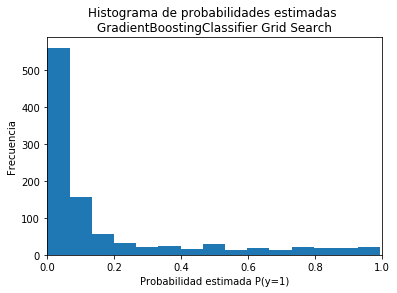

In [76]:
# Vemos Histograms de Probabilidades de Clasificación P(y=1) con 15 bins
plt.hist(y_proba_1, bins=15)

# x-axis de 0 a 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas \n' + nombre_modelo_elegido)
plt.xlabel('Probabilidad estimada P(y=1)')
plt.ylabel('Frecuencia')
plt.show()

In [77]:
# Ahora Vemos las métricas del modelo con el Umbral Óptimo
y_pred = binarize(y_proba, umbral_optimo)[:,1]

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       813
           1       0.66      0.42      0.51       209

   micro avg       0.84      0.84      0.84      1022
   macro avg       0.76      0.68      0.71      1022
weighted avg       0.82      0.84      0.82      1022



Interpretación Classification Report:
- Precision = TP/(TP+FP) -> TP/"Predice Positivo"         [Para Valor 1]
- Precision = TN/(TN+FN) -> TN/"Predice Negativo"         [Para Valor 0]


- Recall (Sensitivity) = TP/(TP+FN) -> TP/"Es Positivo"   [Para Valor 1]
- Recall (Sensitivity) = TN/(TN+FP) -> TN/"Es Negativo"   [Para Valor 0]



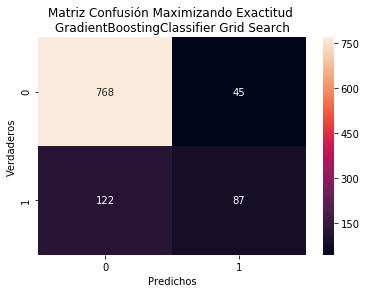

In [79]:
# Elaboramos la matriz de confusión con el umbral que maximiza Accuracy
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')
plt.title('Matriz Confusión Maximizando Exactitud \n' + nombre_modelo_elegido)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.savefig('chart10_matriz_confusion_max_accuracy.pdf', bbox_inches='tight', dpi=600)
plt.show();

In [80]:
accuracy_score(y_test,y_pred)

0.8365949119373777

## 6. Seleccionamos el modelo con el Umbral que minimiza la Función de Costos

#### Función de costos:

FP: "Negocio Perdido": el costo consiste en los interes perdidos de los potenciales clientes rechazados pero que hubieran cancelado el crédito [En promedio, el interés es el 24.9% del valor total de un crédito]

FN: "Costo de la Mora": es el costo total incluye tanto el capital como los intereses perdidos de aquellos clientes a los que se les prestó y resultaron morosos [Representa el 100% del valor total de un crédito promedio]

Por lo tanto cost_fn = FP * 0.249 + FN



In [81]:
# Identificamos el índice correspondiente al modelo con menor función de costos en 
# el DataFrame df_testeo
index_modelo = df_testeo.loc[df_testeo['cost_fn'] == df_testeo['cost_fn'].min(), 
                               :].index[0]
index_modelo

79

In [82]:
# Asignamos las variables al modelo elegido
modelo_elegido = df_testeo.loc[index_modelo, "modelo"]
nombre_modelo_elegido = df_testeo.loc[index_modelo, "nombre"]
umbral_optimo = df_testeo.loc[index_modelo, "umbral"]
corrida_modelo_elegido = df_testeo.loc[index_modelo, "corrida"]
y_proba = modelo_elegido.predict_proba(X_test)

print ('Minimizando Función de Costos:')
print ('Índice = {}'.format(index_modelo))
print ('Corrida = {}'.format(corrida_modelo_elegido))
print ('Modelo = {}'.format(nombre_modelo_elegido))
print ('Umbral Óptimo = {}'.format(umbral_optimo))
print ('Exactitud = {}'.format(df_testeo.loc[index_modelo, "exactitud"]))
print ('Función de Costos = {}'.format(df_testeo.loc[index_modelo, "cost_fn"]))

Minimizando Función de Costos:
Índice = 79
Corrida = 7
Modelo = GradientBoostingClassifier Grid Search
Umbral Óptimo = 0.1
Exactitud = 75.9
Función de Costos = 9.700000000000001


In [83]:
y_proba

array([[0.99040533, 0.00959467],
       [0.94330696, 0.05669304],
       [0.98289295, 0.01710705],
       ...,
       [0.92199181, 0.07800819],
       [0.63434817, 0.36565183],
       [0.05232465, 0.94767535]])

In [84]:
# Seleccionamos las probabilidades de la clase y=1
y_proba_1 = y_proba[:,1]

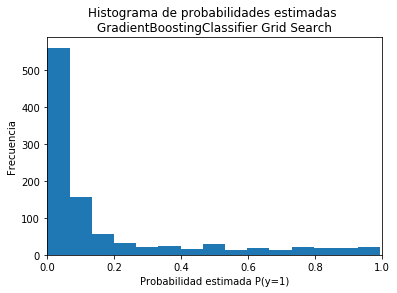

In [85]:
# Vemos Histograms de Probabilidades de Clasificación P(y=1) con 15 bins
plt.hist(y_proba_1, bins=15)

# x-axis de 0 a 1
plt.xlim(0,1)
plt.title('Histograma de probabilidades estimadas \n' + nombre_modelo_elegido)
plt.xlabel('Probabilidad estimada P(y=1)')
plt.ylabel('Frecuencia')
plt.savefig('chart10_histograma_proba_umbral_optimo.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [86]:
# Ahora Vemos las métricas del modelo con el Umbral Óptimo
y_pred = binarize(y_proba, umbral_optimo)[:,1]

In [87]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.83       813
           1       0.45      0.76      0.56       209

   micro avg       0.76      0.76      0.76      1022
   macro avg       0.69      0.76      0.70      1022
weighted avg       0.83      0.76      0.78      1022



Interpretación Classification Report:
- Precision = TP/(TP+FP) -> TP/"Predice Positivo"         [Para Valor 1]
- Precision = TN/(TN+FN) -> TN/"Predice Negativo"         [Para Valor 0]


- Recall (Sensitivity) = TP/(TP+FN) -> TP/"Es Positivo"   [Para Valor 1]
- Recall (Sensitivity) = TN/(TN+FP) -> TN/"Es Negativo"   [Para Valor 0]



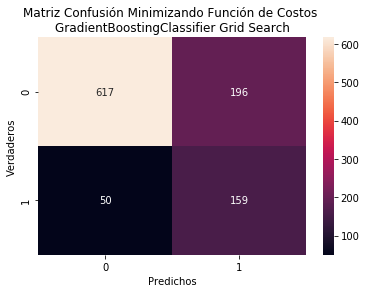

In [88]:
# Elaboramos la matriz de confusión con el umbral óptimo según función de costos
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.title('Matriz Confusión Minimizando Función de Costos \n' + nombre_modelo_elegido)
plt.savefig('chart10_matriz_confusion_umbral_optimo.pdf', bbox_inches='tight', dpi=600)
plt.show();

In [89]:
accuracy_score(y_test,y_pred)

0.7592954990215264

## 7. Graficamos los indicadores para distintos umbrales del modelo seleccionado en 6. (arriba)

In [90]:
df_testeo.columns

Index(['corrida', 'cost_fn', 'exactitud', 'modelo', 'nombre',
       'nueva_mora (FN)', 'precision', 'recall', 'umbral'],
      dtype='object')

In [105]:
df_testeo.head()

,corrida,cost_fn,exactitud,modelo,nombre,nueva_mora (FN),precision,recall,umbral
0,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.00
1,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.05
2,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.10
3,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.15
4,0,14.4,76.8,DecisionTreeClassifier(class_weight='balanced'...,Árbol de decisión,11.4,43.4,44.0,0.20


In [92]:
mascara = df_testeo['corrida'] == corrida_modelo_elegido
mascara.sum()

11

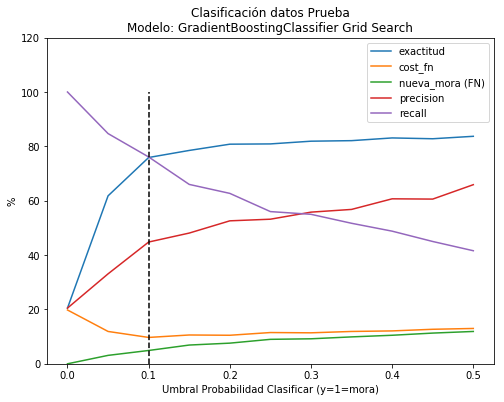

In [93]:
# Evaluamos el gráfico de los indicadores de clasificación vs probabilidad clasificar y=1

plt.figure(figsize=(8, 6))

plt.plot(df_testeo.loc[mascara, 'umbral'], df_testeo.loc[mascara, 'exactitud'], \
            label = 'exactitud')
           
plt.plot(df_testeo.loc[mascara, 'umbral'], df_testeo.loc[mascara, 'cost_fn'], \
            label = 'cost_fn')
           
plt.plot(df_testeo.loc[mascara, 'umbral'], df_testeo.loc[mascara, 'nueva_mora (FN)'], \
            label = 'nueva_mora (FN)')
           
plt.plot(df_testeo.loc[mascara, 'umbral'], df_testeo.loc[mascara, 'precision'], \
            label = 'precision')
           
plt.plot(df_testeo.loc[mascara, 'umbral'], df_testeo.loc[mascara, 'recall'], \
            label = 'recall')

plt.plot([umbral_optimo, umbral_optimo], [0,100], 'k--')


plt.xlabel('Umbral Probabilidad Clasificar (y=1=mora)')
plt.ylabel('%')
plt.ylim(0, 120)
plt.legend(loc = 0)
plt.title('Clasificación datos Prueba\n' + 'Modelo: '+ nombre_modelo_elegido)
plt.savefig('chart10_grafico_clasificacion.pdf', bbox_inches='tight', dpi=600)
plt.show();

## 8a. Generamos un resumen del desempeño de los distintos modelos maximizando Exactidud (Accuracy)

In [94]:
index_list = []
for i in np.arange(0, df_testeo['corrida'].max()+1):
    #print (i)
    df_temp = df_testeo.loc[df_testeo['corrida'] == i,:]
    index_list.append(df_temp.loc[df_temp['exactitud'] == \
                                  df_temp['exactitud'].max(),:].index[0])
    

In [95]:
df_resumen = df_testeo.loc[index_list, :]
df_resumen.index = df_resumen['corrida']
df_resumen = df_resumen[['nombre', 'exactitud', 'cost_fn', 'recall', 'precision',
                           'nueva_mora (FN)', 'umbral']]
df_resumen

,nombre,exactitud,cost_fn,recall,precision,nueva_mora (FN),umbral
corrida,,,,,,,
0,Árbol de decisión,76.8,14.4,44.0,43.4,11.4,0.00
1,Bagging AD,81.4,13.2,44.0,55.8,11.4,0.40
2,Random Forest,82.0,16.2,23.9,66.7,15.6,0.50
3,Random Forest Grid Search,83.2,14.8,31.1,69.9,14.1,0.50
4,Extra Trees,82.2,13.0,44.0,58.6,11.4,0.40
5,AdaBoostClassifier Random Search,81.8,15.0,31.6,60.6,14.0,0.50
6,GradientBoostingClassifier,82.2,16.4,22.0,70.8,15.9,0.50
7,GradientBoostingClassifier Grid Search,83.7,13.0,41.6,65.9,11.9,0.50
8,CatBoostClassifier Random Search,83.4,13.8,37.3,66.7,12.8,0.45


## 8b. Generamos un resumen del desempeño de los distintos modelos minimizando la Función de Costos

In [96]:
index_list = []
for i in np.arange(0, df_testeo['corrida'].max()+1):
    #print (i)
    df_temp = df_testeo.loc[df_testeo['corrida'] == i,:]
    index_list.append(df_temp.loc[df_temp['cost_fn'] == \
                                  df_temp['cost_fn'].min(),:].index[0])
    

In [97]:
df_resumen = df_testeo.loc[index_list, :]
df_resumen.index = df_resumen['corrida']
df_resumen = df_resumen[['nombre', 'exactitud', 'cost_fn', 'recall', 'precision',
                           'nueva_mora (FN)', 'umbral']]
df_resumen

,nombre,exactitud,cost_fn,recall,precision,nueva_mora (FN),umbral
corrida,,,,,,,
0,Árbol de decisión,76.8,14.4,44.0,43.4,11.4,0.00
1,Bagging AD,73.4,11.8,66.5,40.8,6.8,0.20
2,Random Forest,66.8,12.0,75.6,35.4,5.0,0.10
3,Random Forest Grid Search,79.4,9.9,68.9,49.7,6.4,0.25
4,Extra Trees,79.1,10.4,66.0,49.1,6.9,0.20
5,AdaBoostClassifier Random Search,81.8,15.0,31.6,60.6,14.0,0.50
6,GradientBoostingClassifier,75.9,10.5,70.8,44.4,6.0,0.20
7,GradientBoostingClassifier Grid Search,75.9,9.7,76.1,44.8,4.9,0.10
8,CatBoostClassifier Random Search,70.9,10.5,78.5,39.4,4.4,0.15


## 9a. Evaluamos la Importancia de las principales "Features" (Versión Sklearn)

In [98]:
importancias = modelo_elegido.feature_importances_

In [99]:
#modelo_elegido.estimators_[0][0]
modelo_elegido.estimators_[0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=6,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x10861cd80>,
           splitter='best')], dtype=object)

In [100]:
# Calculamos la desviación estándar de la importacia de los features haciendo un bucle sobre los árboles en el random forest
#std = np.std([tree.feature_importances_ for tree in modelo_elegido.estimators_], axis=0)

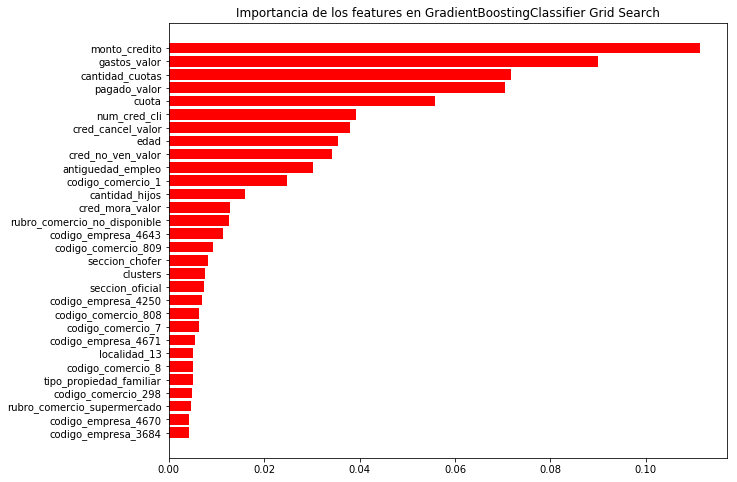

In [101]:
features_limit = 30
#indices = np.argsort(importancias)
indices = np.argsort(importancias)[::-1]
indices = indices[0:features_limit]
indices = indices[::-1]
nombres_features = X.columns

# Graficar la importancia de los features en el modelo elegido
plt.figure(figsize=(10, 8))
plt.title("Importancia de los features en " + nombre_modelo_elegido)
plt.barh(range(features_limit), importancias[indices], 
       color="r", align="center") #yerr=std[indices],
plt.yticks(range(features_limit), nombres_features[indices])
plt.savefig('chart12_feature_importance.pdf', bbox_inches='tight', dpi=600)
plt.show();

## 9b. Evaluamos la Importancia de las principales "Features" (Versión CatBoost

In [102]:
importancias = modelo_elegido.feature_importances_

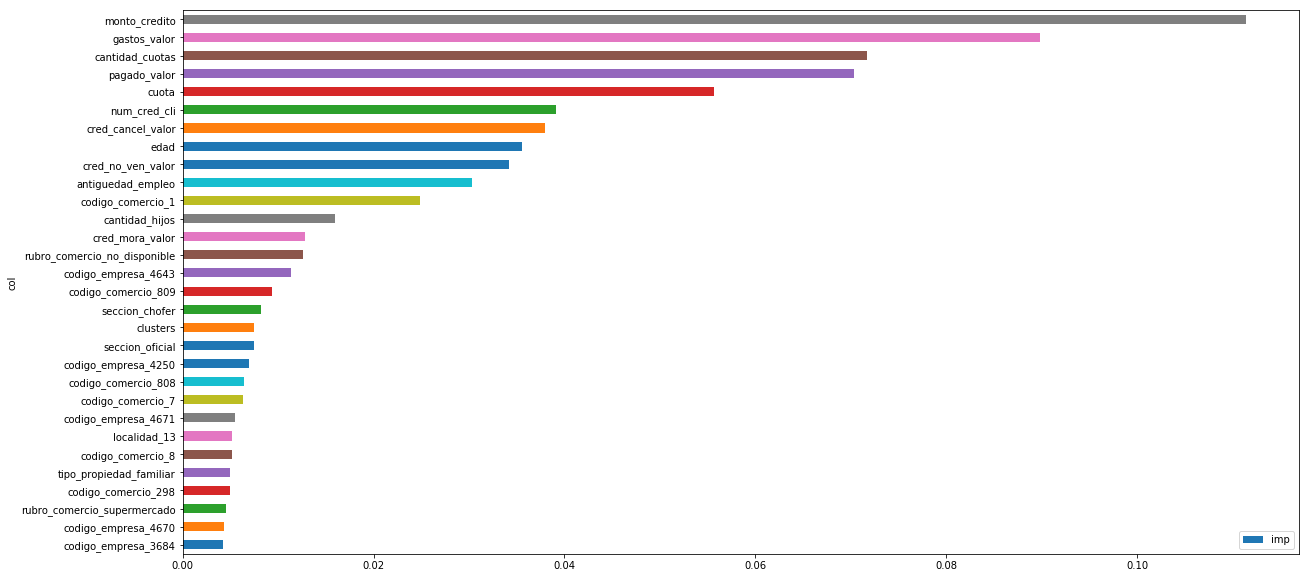

In [103]:
fea_imp = pd.DataFrame({'imp': importancias, 'col': X_test.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png') 